In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from astroquery.vizier import Vizier

First, be sure to refer to the [Vizier ZFOURGE Querying and Data Processing](https://github.com/mjcowley/Astro_Code/tree/main/ZFOURGE-VizieR-Import) notebook on how to load the data.

In [2]:
# Load required catalogs
flux_catalog = "J/ApJ/830/51/cosflux"  # Rest-frame flux catalog
use_catalog = "J/ApJ/830/51/zf_cosmos"  # "Use" catalog
sfr_catalog = "J/ApJ/830/51/cosmossfr"  # Stellar mass catalog
z_catalog = "J/ApJ/830/51/cosmosz"  # Photometric redshift catalog

In [3]:
# Define columns to load
flux_columns = ['Seq', 'FU', 'FV', 'FJ'] # Rest-frame U, V, J band fluxes
use_columns = ['Seq', 'use'] # Use column
sfr_columns = ['Seq', 'lmass', 'lssfr'] # Stellar mass and specific star formation rate
z_columns = ['Seq', 'zp'] # Photometric redshift

In [4]:
# Load dataframes
flux_data = Vizier(columns=flux_columns, row_limit=-1).query_constraints(catalog=flux_catalog)[0].to_pandas()
use_data = Vizier(columns=use_columns, row_limit=-1).query_constraints(catalog=use_catalog)[0].to_pandas()
sfr_data = Vizier(columns=sfr_columns, row_limit=-1).query_constraints(catalog=sfr_catalog)[0].to_pandas()
z_data = Vizier(columns=z_columns, row_limit=-1).query_constraints(catalog=z_catalog)[0].to_pandas()

In [5]:
# Set Seq as the index for all datasets before merging
flux_data = flux_data.set_index('Seq')
use_data = use_data.set_index('Seq')
sfr_data = sfr_data.set_index('Seq')
z_data = z_data.set_index('Seq')


In [6]:
# Ensure common `Seq` values across all datasets
common_seq = set(flux_data.index) & set(use_data.index) & set(sfr_data.index) & set(z_data.index)

In [7]:
common_seq = sorted(common_seq)   # or list(common_seq)

flux_data = flux_data.loc[common_seq]
use_data  = use_data.loc[common_seq]
sfr_data  = sfr_data.loc[common_seq]
z_data    = z_data.loc[common_seq]

In [8]:
# Merge datasets
merged_data = pd.concat([flux_data, use_data, sfr_data, z_data], axis=1)

The values in the rest-frame catalog were generated by fitting the photometry of the galaxies with a set of SED templates. The templates were then de-redshifted to the rest-frame and the fluxes were measured in a set of filters. The filters used are as follows:

| Filter | Description                                      |
|--------|--------------------------------------------------|
| `u`    | SDSS `u` filter                                  |
| `g`    | SDSS `g` filter                                  |
| `r`    | SDSS `r` filter                                  |
| `i`    | SDSS `i` filter                                  |
| `z`    | SDSS `z` filter                                  |
| `U`    | Johnson `U` filter                               |
| `B`    | Johnson `B` filter                               |
| `V`    | Johnson `V` filter                               |
| `J`    | 2MASS `J` filter                                 |
| `H`    | 2MASS `H` filter                                 |
| `K`    | 2MASS `K` filter                                 |
| `uv13` | Tophat filter, 110 Å wide, centred at 1300 Å     |
| `uv15` | Tophat filter, 350 Å wide, centred at 1500 Å     |
| `uv19` | Tophat filter, 350 Å wide, centred at 1900 Å     |
| `uv22` | Tophat filter, 350 Å wide, centred at 2200 Å     |
| `uv28` | Tophat filter, 350 Å wide, centred at 2800 Å     |

### Conversion Notes
1. **Units:** This fluxes in the rest-frame catalog are in units of $\mu\text{Jy}$.

2. **Conversion to AB Flux Densities:**
   To convert back to catalogue fluxes (AB flux densities with zeropoint 25), divide by:
   $10^{\frac{23.9 - 25}{2.5}}$

3. **Conversion to AB Magnitudes:**
   To convert flux density in $\mu\text{Jy}$ to AB magnitudes, use:
   $m_{\text{AB}} = 25 - 2.5 \log_{10}(f)$

   where $f$ is the rest-frame flux density in $\mu\text{Jy}$.

4. **Conversion to Solar Luminosities:**

   - **Step 1:** Convert to $\text{ergs/cm}^2/\text{s}/\text{Å}$ using the formula:
     $\text{flux density} \; [\mu\text{Jy}] \times 10^{-29} \times 3 \times 10^{18} / \lambda_c^2$,
     where $\lambda_c$ is the central wavelength of the filter bandpass.

   - **Step 2:** Convert from flux density to flux by multiplying by $\lambda_c$:
     $\text{flux} = \text{flux density} \times \lambda_c$

   - **Step 3:** Convert from flux to luminosity using the distance modulus:
     $\text{distance} = 10^{\left(\frac{\text{DM} + 5}{5}\right)} \times 3.086 \times 10^{18}$
     $L = \text{flux} \times 4 \pi \times \text{distance}^2 / (1 + z)$

   - **Step 4:** Convert to solar luminosities:
     $L_\odot = \frac{L}{3.828 \times 10^{33}}$

For a UVJ diagram, we need to calculate the rest-frame UVJ colours. The UVJ colours are defined as follows:

- **U-V:** $m_{\text{U}} - m_{\text{V}}$
- **V-J:** $m_{\text{V}} - m_{\text{J}}$

where $m_{\text{U}}$, $m_{\text{V}}$, and $m_{\text{J}}$ are the AB magnitudes in the rest-frame U, V, and J bands, respectively.

In [9]:
# Let's limit the redshift range to 0.5 < z < 3.5 and the stellar mass to lmass > 10
z_min, z_max = 0.5, 3.5  # Redshift range
lmass_cut = 10  # Minimum stellar mass

# Filter data based on use, redshift range, and mass cut
filtered_data = merged_data[
    (merged_data['Use'] == 1) &
    (merged_data['zp'] >= z_min) &
    (merged_data['zp'] <= z_max) &
    (merged_data['lmass'] > lmass_cut)
]

# Extract the fluxes
FU = filtered_data['FU']  # Rest-frame U-band flux
FV = filtered_data['FV']  # Rest-frame V-band flux
FJ = filtered_data['FJ']  # Rest-frame J-band flux

# Convert to AB magnitudes
mU = 25 - 2.5 * np.log10(FU)  # Rest-frame U-band magnitude
mV = 25 - 2.5 * np.log10(FV)  # Rest-frame V-band magnitude
mJ = 25 - 2.5 * np.log10(FJ)  # Rest-frame J-band magnitude

# Calculate the UVJ colours
UV = mU - mV  # U-V colour
VJ = mV - mJ  # V-J colour

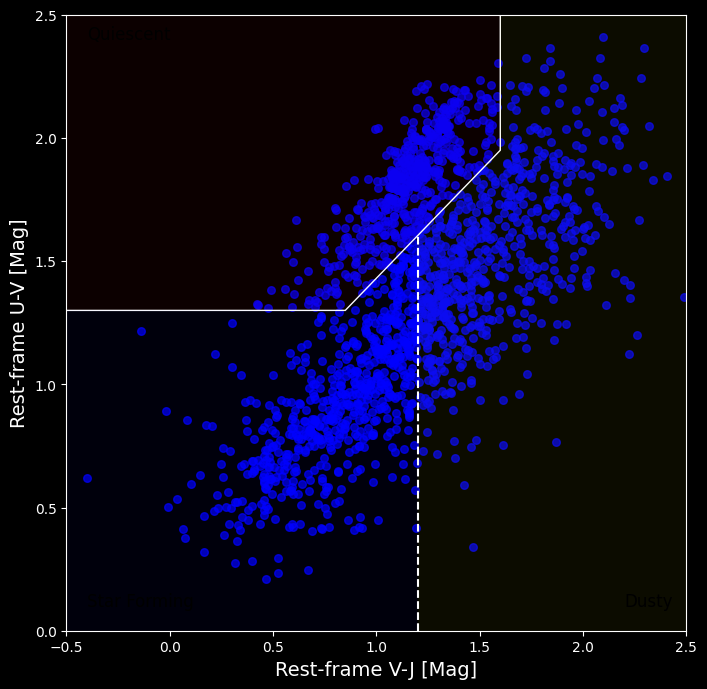

In [10]:
# Plot the UVJ diagram

plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
plt.scatter(VJ, UV, c='blue', s=30, alpha=0.7)  # Remove colormap, use a single colour
plt.xlim([-0.5, 2.5])
plt.ylim([0, 2.5])
plt.xlabel('Rest-frame V-J [Mag]', fontsize=14)
plt.ylabel('Rest-frame U-V [Mag]', fontsize=14)

# Define UVJ regions
quiescent_region = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
sf_region = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
dusty_region = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.5, 2.5], [2.5, 0.0]]

# Add polygons for the regions
ax.add_patch(patches.Polygon(quiescent_region, closed=True, fill=True, facecolor=(1, 0, 0, 0.05), edgecolor='white', linewidth=1))
ax.add_patch(patches.Polygon(sf_region, closed=True, fill=True, facecolor=(0, 0, 1, 0.05)))
ax.add_patch(patches.Polygon(dusty_region, closed=True, fill=True, facecolor=(1, 1, 0, 0.05)))

# Add vertical line separating star-forming and dusty star-forming regions
plt.axvline(1.2, color='white', linestyle='--', ymin=0, ymax=1.60333 / 2.5)

# Add annotations for regions
plt.annotate('Quiescent', xy=(-0.4, 2.4), color='black', fontsize=12)
plt.annotate('Star Forming', xy=(-0.4, 0.1), color='black', fontsize=12)
plt.annotate('Dusty', xy=(2.2, 0.1), color='black', fontsize=12)

plt.show()

Let's compare the UVJ diagram with the specific star formation rate (sSFR) of the galaxies. The sSFR is defined as the ratio of the star formation rate (SFR) to the stellar mass (M$_\star$) of the galaxy.

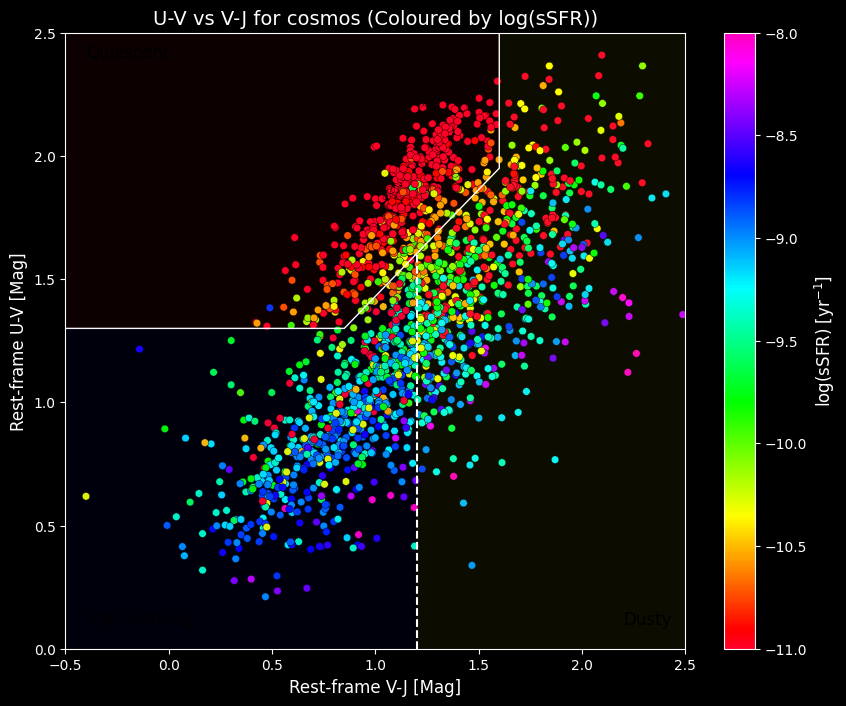

In [11]:
filtered_data = filtered_data.copy()  # Ensure not to modify the original filtered data
filtered_data['lssfr_clipped'] = filtered_data['lssfr'].clip(-11, -8) # Ignore outliers below -11 and above -8
norm = plt.Normalize(vmin=-11, vmax=-8)  # Normalise the lssfr values
colors = mpl.colormaps['gist_rainbow'](norm(filtered_data['lssfr_clipped'])) # Get colours based on lssfr values

# Plot the UVJ diagram with colours
plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)
plt.scatter(VJ, UV, c=colors, s=30, edgecolor='k', linewidth=0.3)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='gist_rainbow'), ax=ax)
cbar.set_label('log(sSFR) [yr$^{-1}$]', fontsize=12)
plt.xlim([-0.5, 2.5])
plt.ylim([0, 2.5])
plt.title('U-V vs V-J for cosmos (Coloured by log(sSFR))', fontsize=14)
plt.xlabel('Rest-frame V-J [Mag]', fontsize=12)
plt.ylabel('Rest-frame U-V [Mag]', fontsize=12)

# Define UVJ regions
quiescent_region = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
sf_region = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
dusty_region = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.5, 2.5], [2.5, 0.0]]

# Add polygons for the regions
ax.add_patch(patches.Polygon(quiescent_region, closed=True, fill=True, facecolor=(1, 0, 0, 0.05), edgecolor='white', linewidth=1))
ax.add_patch(patches.Polygon(sf_region, closed=True, fill=True, facecolor=(0, 0, 1, 0.05)))
ax.add_patch(patches.Polygon(dusty_region, closed=True, fill=True, facecolor=(1, 1, 0, 0.05)))

# Add vertical line separating star-forming and dusty star-forming regions
plt.axvline(1.2, color='white', linestyle='--', ymin=0, ymax=1.60333 / 2.5)

# Add annotations for regions
plt.annotate('Quiescent', xy=(-0.4, 2.4), color='black', fontsize=12)
plt.annotate('Star Forming', xy=(-0.4, 0.1), color='black', fontsize=12)
plt.annotate('Dusty', xy=(2.2, 0.1), color='black', fontsize=12)

plt.show()

As you can see, galaxies with lower specific star formation rates (sSFR) tend to be located in the quiescent region of the UVJ diagram, while galaxies with higher sSFR are found in the star-forming region.